# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

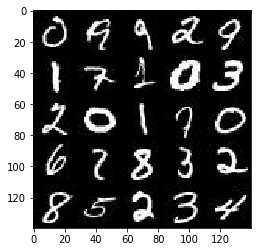

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

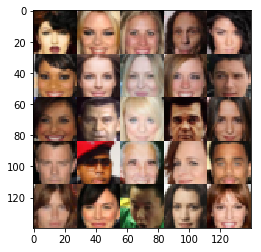

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(dtype=tf.float32,
                                  shape=[None, image_width, image_height, image_channels],
                                  name='input_images')
    z_data = tf.placeholder(dtype=tf.float32,
                            shape=[None, z_dim],
                            name='z_data')
    learning_rate = tf.placeholder(dtype=tf.float32,
                                   name='learning_rate')

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Leaky ReLU
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # input image: 28x28x(3 or 1)
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        # 14x14x64
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same', activation=None)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        # 8x8x128
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same', activation=None)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
 
        # 4x4x256 with flatten
        flatten = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # Leaky ReLU
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # input noise
        h1 = tf.layers.dense(z, 4*4*512, activation=None)
        # reshape
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        # 4x4x512
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same', activation=None)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        # 8x8x256
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding='same', activation=None)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        # 16x16x128
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=2, padding='same')
        
        # 32x32x(3 or 1) and should be resized
        logits = tf.image.resize_images(logits, size=[28,28])
        
        # 28x28x(3 or 1)
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    show_n_images = 25
    print_every = 10
    show_every = 100
    steps = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0101... Generator Loss: 5.5046
Epoch 1/2... Discriminator Loss: 2.0889... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 0.7858... Generator Loss: 2.8603
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 2.5361
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 2.6303... Generator Loss: 0.1392
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 5.0718


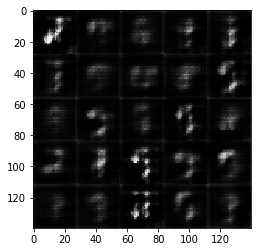

Epoch 1/2... Discriminator Loss: 0.2847... Generator Loss: 2.6315
Epoch 1/2... Discriminator Loss: 3.1580... Generator Loss: 11.4082
Epoch 1/2... Discriminator Loss: 0.0746... Generator Loss: 3.5417
Epoch 1/2... Discriminator Loss: 0.0737... Generator Loss: 3.5245
Epoch 1/2... Discriminator Loss: 0.1416... Generator Loss: 2.8412
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 1.3344
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.5286
Epoch 1/2... Discriminator Loss: 1.8748... Generator Loss: 7.8974
Epoch 1/2... Discriminator Loss: 0.1432... Generator Loss: 3.3702
Epoch 1/2... Discriminator Loss: 0.0870... Generator Loss: 3.8355


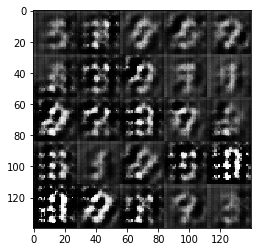

Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 1.8876
Epoch 1/2... Discriminator Loss: 0.1439... Generator Loss: 2.6461
Epoch 1/2... Discriminator Loss: 0.0663... Generator Loss: 3.5030
Epoch 1/2... Discriminator Loss: 1.1058... Generator Loss: 8.3246
Epoch 1/2... Discriminator Loss: 0.2596... Generator Loss: 2.0913
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 2.2000... Generator Loss: 0.2183
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.5382
Epoch 1/2... Discriminator Loss: 0.8893... Generator Loss: 0.8768


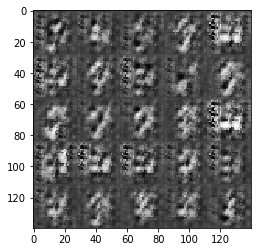

Epoch 1/2... Discriminator Loss: 0.1661... Generator Loss: 4.5117
Epoch 1/2... Discriminator Loss: 0.4693... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 1.4295
Epoch 1/2... Discriminator Loss: 0.4337... Generator Loss: 5.9930
Epoch 1/2... Discriminator Loss: 0.0544... Generator Loss: 4.5613
Epoch 1/2... Discriminator Loss: 4.1988... Generator Loss: 0.0518
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 1.7228
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.5999


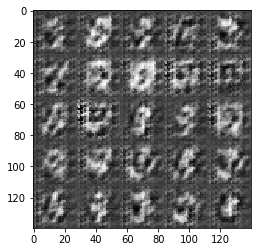

Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 1.1646
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 1.9251
Epoch 1/2... Discriminator Loss: 0.5418... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 0.4807... Generator Loss: 2.2202
Epoch 1/2... Discriminator Loss: 0.3816... Generator Loss: 1.5428
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.9415
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 0.5923... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 1.5759
Epoch 2/2... Discriminator Loss: 0.2030... Generator Loss: 2.0493


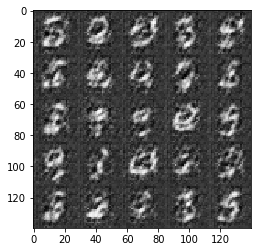

Epoch 2/2... Discriminator Loss: 0.1264... Generator Loss: 3.3637
Epoch 2/2... Discriminator Loss: 0.1121... Generator Loss: 5.9802
Epoch 2/2... Discriminator Loss: 5.3453... Generator Loss: 0.0094
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.2418
Epoch 2/2... Discriminator Loss: 1.2085... Generator Loss: 0.5152
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.4137
Epoch 2/2... Discriminator Loss: 0.4660... Generator Loss: 2.0836
Epoch 2/2... Discriminator Loss: 0.5350... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 1.6969


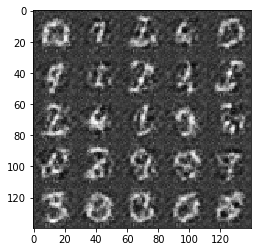

Epoch 2/2... Discriminator Loss: 1.7753... Generator Loss: 0.2702
Epoch 2/2... Discriminator Loss: 0.3167... Generator Loss: 2.1316
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 1.7907
Epoch 2/2... Discriminator Loss: 0.3277... Generator Loss: 1.9697
Epoch 2/2... Discriminator Loss: 3.5266... Generator Loss: 7.9712
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 0.1109... Generator Loss: 3.5923
Epoch 2/2... Discriminator Loss: 0.1024... Generator Loss: 3.0799
Epoch 2/2... Discriminator Loss: 0.0288... Generator Loss: 5.0345


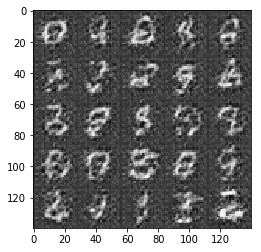

Epoch 2/2... Discriminator Loss: 0.0304... Generator Loss: 6.0099
Epoch 2/2... Discriminator Loss: 0.0923... Generator Loss: 2.8235
Epoch 2/2... Discriminator Loss: 3.8224... Generator Loss: 6.4392
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.5405
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 1.6458
Epoch 2/2... Discriminator Loss: 0.5459... Generator Loss: 2.2534
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 4.0036
Epoch 2/2... Discriminator Loss: 0.4494... Generator Loss: 1.5357


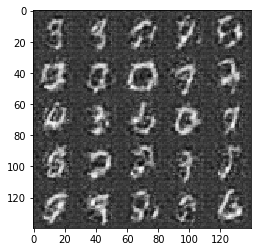

Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 0.1847... Generator Loss: 2.6362
Epoch 2/2... Discriminator Loss: 0.1041... Generator Loss: 2.8580
Epoch 2/2... Discriminator Loss: 0.0939... Generator Loss: 3.7018
Epoch 2/2... Discriminator Loss: 0.0747... Generator Loss: 3.1371
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 2.6105
Epoch 2/2... Discriminator Loss: 0.8183... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 0.5871... Generator Loss: 2.4290
Epoch 2/2... Discriminator Loss: 0.4777... Generator Loss: 1.6981


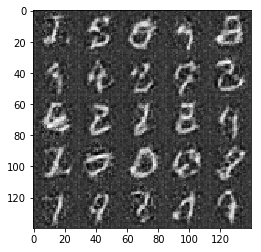

Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 5.0515
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 1.9325


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.2107... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 0.1400... Generator Loss: 3.5675
Epoch 1/1... Discriminator Loss: 0.2355... Generator Loss: 2.2679
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 7.0426
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 2.8337
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 3.4525
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.3140


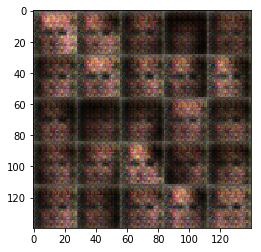

Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 1.7025
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 2.4639
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 2.5453
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 4.8986
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 4.2779
Epoch 1/1... Discriminator Loss: 3.8819... Generator Loss: 0.0321
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.6115


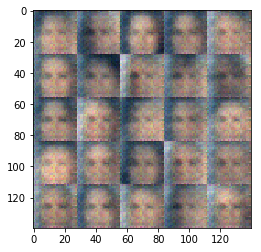

Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7869


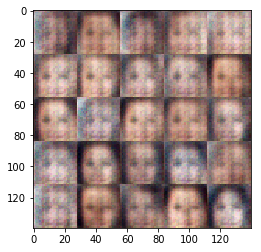

Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.8102


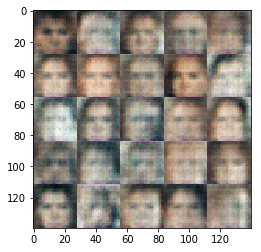

Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.6280


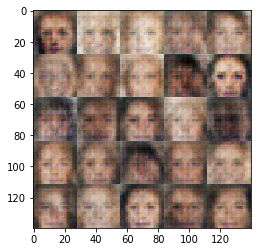

Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.2776
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8244


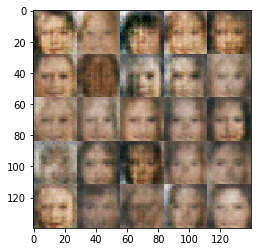

Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 2.0530


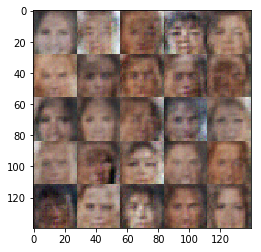

Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 3.4564
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 3.4700


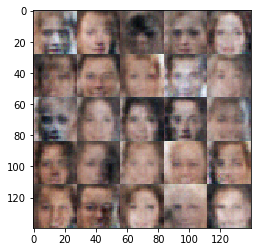

Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 2.4220
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 3.3001
Epoch 1/1... Discriminator Loss: 0.2392... Generator Loss: 5.7385
Epoch 1/1... Discriminator Loss: 1.9034... Generator Loss: 0.2014
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 4.0978
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 3.3048
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 5.0860


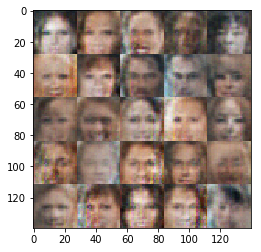

Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 3.4857
Epoch 1/1... Discriminator Loss: 0.6354... Generator Loss: 3.5611
Epoch 1/1... Discriminator Loss: 2.3089... Generator Loss: 0.1318
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.1478... Generator Loss: 3.0533
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 1.6455
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 0.2670... Generator Loss: 6.2806
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 1.5274


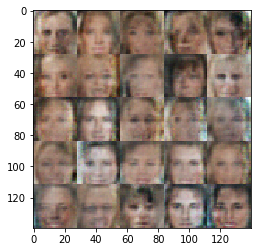

Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 0.2180... Generator Loss: 3.6848
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 7.0092
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 5.1001
Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 6.2246
Epoch 1/1... Discriminator Loss: 2.3443... Generator Loss: 0.1415
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.8831


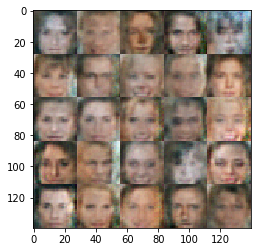

Epoch 1/1... Discriminator Loss: 0.1137... Generator Loss: 4.4463
Epoch 1/1... Discriminator Loss: 0.1044... Generator Loss: 4.5008
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 0.2709... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 8.0312
Epoch 1/1... Discriminator Loss: 0.1511... Generator Loss: 2.5739
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 3.2552
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 7.8419
Epoch 1/1... Discriminator Loss: 0.1760... Generator Loss: 3.8622
Epoch 1/1... Discriminator Loss: 0.2806... Generator Loss: 4.0582


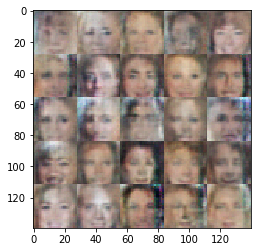

Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 2.9315
Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 2.9278
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 2.8796
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 0.0758... Generator Loss: 5.0849
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 2.1161
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 2.3463


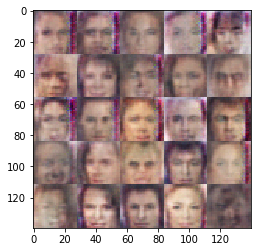

Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 1.3649


In [ ]:
batch_size = 128
z_dim = 250
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.